# Ingredients: Download and Detection

by Michael Berger

**Sources:**
- Horea Muresan, Mihai Oltean, Fruit recognition from images using deep learning, Acta Univ. Sapientiae, Informatica Vol. 10, Issue 1, pp. 26-42, 2018.
- Scraping Google Images
- https://github.com/marcusklasson/GroceryStoreDataset
- https://github.com/PhilJd/freiburg_groceries_dataset

In [1]:
# Loading libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import cv2

from keras import backend as K
from keras.optimizers import Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda
import tensorflow as tf
from PIL import ImageFile

Using TensorFlow backend.


In [2]:
# Allowing to load truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# Paramaters for learning the ingredients detection mode

# NN parameters
epochs = 20
batch_size = 25
validation_percent = 0.2
learning_rate = 0.1 # initial learning rate
min_learning_rate = 0.00001  # threshold to stop reducing learning rate
learning_rate_reduction_factor = 0.5  # learning_rate *= learning_rate_reduction_factor
patience = 3  # how many epochs to wait before reducing the learning rate when the loss plateaus
verbose = 1  # controls the amount of logging done during training and testing: 0 - none, 1 - reports metrics after each batch, 2 - reports metrics after each epoch
image_size = (100, 100)  # width and height of the used images
input_shape = (100, 100, 3)
weight = 0.01 #L2 weight

# Input and output parameters
use_label_file = True  # set this to true if you want load the label names from a file; uses the label_file defined below; the file should contain the names of the used labels, each label on a separate line
label_file = 'labels.txt'
base_dir = '/home/miber' # for data and output files
train_dir = os.path.join(base_dir, 'data/ingredients-images/ingredients-train')
test_dir = os.path.join(base_dir, 'data/ingredients-images/ingredients-test')
output_dir = 'ingredients_training_output_files'

In [4]:
# Loading labels
label_file = label_file
with open(label_file, "r") as f:
    labels = [x.rstrip('\n') for x in f.readlines()]

In [5]:
labels

['Walnut',
 'Steak',
 'Orange',
 'Clam',
 'Honey',
 'Romanesco',
 'Pomelo',
 'Dates',
 'Mulberry',
 'Cantaloupe',
 'Pitahaya',
 'Mushroom',
 'Cocos',
 'Rice',
 'Eggplant',
 'Pesto_Sauce',
 'Pasta',
 'Bok_Choi',
 'Tomato',
 'Quince',
 'Flax_Seed',
 'Pineapple',
 'Grapefruit',
 'Vinegar',
 'Yoghurt',
 'Heavy_Cream',
 'Plum',
 'Green_Cabbage',
 'Asparagus',
 'Hazelnut',
 'Cucumber',
 'Kale',
 'Pomegranate',
 'Rambutan',
 'Cactus_Fruit',
 'Maracuja',
 'Nut_Pecan',
 'Lemon',
 'Tuna_Steak',
 'Apple',
 'Granadilla',
 'Peach',
 'Mangostan',
 'Flour',
 'Tomato_Sauce',
 'Lettuce',
 'Guava',
 'Beans',
 'Mandarin_Orange',
 'Strawberry',
 'Leek',
 'Passion_Fruit',
 'Kiwi',
 'Oat_Milk',
 'Pumpkin',
 'Watermelon',
 'Banana_Red',
 'Sugar',
 'Physalis',
 'Bulgur',
 'Corn',
 'Kohlrabi',
 'Artichoke',
 'Goji_Berry',
 'Coconut_Milk',
 'Apricot',
 'Cherry',
 'Cabbage',
 'Blueberries',
 'Kumquats',
 'Tahini',
 'Cauliflower',
 'Garlic',
 'Huckleberry',
 'Pork',
 'Tamarillo',
 'Lime',
 'Grape',
 'Oil',
 'Ging

In [6]:
datagen = ImageDataGenerator()
gen = datagen.flow_from_directory(train_dir, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=False, subset=None, classes=labels)
gen.class_indices

Found 63274 images belonging to 119 classes.


{'Apple': 39,
 'Apricot': 65,
 'Artichoke': 62,
 'Artichoke_Hearts': 88,
 'Asparagus': 28,
 'Avocado': 100,
 'Banana': 117,
 'Banana_Red': 56,
 'Beans': 47,
 'Beetroot': 112,
 'Bell_Pepper': 87,
 'Black_Coffee': 91,
 'Blue_Cheese': 104,
 'Blueberries': 68,
 'Bok_Choi': 17,
 'Brie_Cheese': 90,
 'Bulgur': 59,
 'Cabbage': 67,
 'Cactus_Fruit': 34,
 'Cantaloupe': 9,
 'Carambula': 99,
 'Carrots': 115,
 'Cauliflower': 71,
 'Celery': 98,
 'Cherry': 66,
 'Chestnut': 103,
 'Clam': 3,
 'Clementine': 109,
 'Coconut_Milk': 64,
 'Cocos': 12,
 'Corn': 60,
 'Cucumber': 30,
 'Dates': 7,
 'Eggplant': 14,
 'Eggs': 93,
 'Flax_Seed': 20,
 'Flour': 43,
 'Garlic': 72,
 'Ginger_Root': 79,
 'Goji_Berry': 63,
 'Granadilla': 40,
 'Grape': 77,
 'Grapefruit': 22,
 'Green_Cabbage': 27,
 'Guava': 46,
 'Hazelnut': 29,
 'Heavy_Cream': 25,
 'Honey': 4,
 'Huckleberry': 73,
 'Jackfruit': 82,
 'Kaki': 105,
 'Kale': 31,
 'Kiwi': 52,
 'Kohlrabi': 61,
 'Kumquats': 69,
 'Leek': 50,
 'Lemon': 37,
 'Lettuce': 45,
 'Lime': 76,
 

In [7]:
# Set up image preprocessing: Background removal
# source: https://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image

def preprocess_background(input_img):
    #== Libraries =======================================================================
    import numpy as np
    import cv2
    
    #== Parameters =======================================================================
    BLUR = 21
    CANNY_THRESH_1 = 10
    CANNY_THRESH_2 = 200
    MASK_DILATE_ITER = 10
    MASK_ERODE_ITER = 10
    MASK_COLOR = (0.0,0.0,1.0) # In BGR format
    
    image_size = (100, 100)  # width and height of the used images
    input_shape = (100, 100, 3)


    #== Processing =======================================================================

    #-- Convert image -----------------------------------------------------------------------
    img = (input_img*255).astype(np.uint8)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    #-- Edge detection -------------------------------------------------------------------
    edges = cv2.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv2.dilate(edges, None)
    edges = cv2.erode(edges, None)

    #-- Find contours in edges, sort by area ---------------------------------------------
    contour_info = []
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    for c in contours:
        contour_info.append((
            c,
            cv2.isContourConvex(c),
            cv2.contourArea(c),
        ))
        
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]

    #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv2.fillConvexPoly(mask, max_contour[0], (255))

    #-- Smooth mask, then blur it --------------------------------------------------------
    mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask

    #-- Blend masked img into MASK_COLOR background --------------------------------------
    mask_stack  = mask_stack.astype('float32') / 255.0          # Use float matrices, 
    img         = img.astype('float32') / 255.0                 #  for easy blending

    masked = (mask_stack * img) + ((1-mask_stack) * MASK_COLOR) # Blend
    masked = (masked * 255).astype('uint8')                     # Convert back to 8-bit
    
    image = cv2.resize(masked, image_size)
    image = np.reshape(image, input_shape)
    
    return image

In [8]:
# Set-up for model
# Based on https://github.com/Horea94/Fruit-Images-Dataset

# Setting up output folder
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loading labels
if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.rstrip('\n') for x in f.readlines()]
else:
    labels = os.listdir(train_dir)
    
num_classes = len(labels)


# Functions for plotting, data generator and model evaluation
def plot_model_history(model_history, out_path=""):
    '''
    Creating one accuracy and one loss chart over epochs
    '''
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1), len(model_history.history['accuracy']))
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1), len(model_history.history['loss']))
    axs[1].legend(['train', 'val'], loc='best')
    
    # save the graph in a file called "acc_loss.png" to be available for later
    # the model_name is provided when creating and training a model
    if out_path:
        plt.savefig(out_path + "/acc_loss.png")
    plt.show()


def plot_confusion_matrix(y_true, y_pred, classes, out_path=""):
    '''
    Creates a confusion matrix to visually represent incorrectly classified images
    '''
    
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in classes], columns=[i for i in classes])
    plt.figure(figsize=(40, 40))
    ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=0.2, cbar_kws={"shrink": 0.9})
    
    if out_path:
        plt.savefig(out_path + "/confusion_matrix.png")  # as in the plot_model_history, the matrix is saved in a file called "model_name_confusion_matrix.png"
    
    return ax


# builds a training and validation generator
def build_data_generators(train_folder, test_folder, validation_percent=0.2, labels=None, 
                          image_size=image_size, batch_size=50):
    '''
    Builds training and validation generator from training dataset
    '''
    
    # It should randomly flip images
    train_datagen = ImageDataGenerator(
        width_shift_range=0.0,
        height_shift_range=0.0,
        zoom_range=0.0,
        horizontal_flip=True,
        vertical_flip=True,  
        validation_split=validation_percent)

    train_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=True, 
                                                  subset='training', classes=labels)
    
    validation_gen = train_datagen.flow_from_directory(train_folder, target_size=image_size, class_mode='sparse',
                                                       batch_size=batch_size, shuffle=False, 
                                                       subset='validation', classes=labels)
    
#     test_datagen = ImageDataGenerator() #preprocessing_function=preprocess_background
    
#     test_gen = test_datagen.flow_from_directory(test_folder, target_size=image_size, class_mode='sparse',
#                                                   batch_size=batch_size, shuffle=False, subset=None, classes=labels)
    
    return train_gen, validation_gen#, test_gen


def train_and_evaluate_model(model, name="", epochs=epochs, batch_size=batch_size, 
                             validation_percent=validation_percent, verbose=verbose, 
                             loss='categorical_hinge', use_checkpoint=False):
    '''
    Training and evaluating the model
    
    The batch size is used to determine the number of images passed through the network at once, 
    the number of steps per epochs is derived from this as (total number of images in set // batch size) + 1
    '''
    
    print(model.summary())
    
    model_out_dir = os.path.join(output_dir, name)
    
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)
        
    if use_checkpoint:
        model.load_weights(model_out_dir + "/model.h5")

    trainGen, validationGen = build_data_generators(train_dir, test_dir, validation_percent=validation_percent, 
                                                    labels=labels, image_size=image_size, batch_size=batch_size)
    
    print('Training directory:\n', train_dir)
    
    optimizer = Adadelta(lr=learning_rate)
    
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose, 
                                                factor=learning_rate_reduction_factor, min_lr=min_learning_rate)
    
    save_model = ModelCheckpoint(filepath=model_out_dir + "/model.h5", monitor='val_accuracy', verbose=verbose, 
                                 save_best_only=True, save_weights_only=False, mode='max', period=1)
    
    history = model.fit_generator(generator=trainGen,
                                  epochs=epochs,
                                  steps_per_epoch=(trainGen.n // batch_size) + 1,
                                  validation_data=validationGen,
                                  validation_steps=(validationGen.n // batch_size) + 1,
                                  verbose=verbose,
                                  callbacks=[learning_rate_reduction, save_model])

    model.load_weights(model_out_dir + "/model.h5")

    validationGen.reset()
    loss_v, accuracy_v = model.evaluate_generator(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)
    
    print("\n\nValidation: accuracy = {}\nloss_v = {}\n".format(accuracy_v, loss_v))
    
#     loss_t, accuracy_t = model.evaluate_generator(testGen, steps=(testGen.n // batch_size) + 1, verbose=verbose)
    
#     print("Hold out set: accuracy = %f  ;  loss = %f" % (loss_t, accuracy_t))
    
    plot_model_history(history, out_path=model_out_dir)
    
    validationGen.reset()
    predictions = model.predict_generator(validationGen, steps=(validationGen.n // batch_size) + 1, verbose=verbose)
    y_pred = np.rint(predictions)
    y_true = validationGen.classes
    
    precision = precision_score(y_true, y_pred.argmax(axis=-1), average='weighted')
    print('Validation Precision: %f' % precision)

    recall = recall_score(y_true, y_pred.argmax(axis=-1), average='weighted')
    print('Validation Recall: %f' % recall)

    f1 = f1_score(y_true, y_pred.argmax(axis=-1), average='weighted')
    print('Validation F1 score: %f' % f1)
    
    plot_confusion_matrix(y_true, y_pred.argmax(axis=-1), labels, out_path=model_out_dir)
    class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)
    
    with open(model_out_dir + "/classification_report.txt", "w") as text_file:
        text_file.write("%s" % class_report)


In [9]:
# check it is running on gpu
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.config.experimental.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13626678651778013905
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7900228228464338923
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9066226304307544458
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11235482010
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3852745097191611398
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 100, 100, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 100, 100, 4)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1616      
_________________________________________________________________
conv1_relu (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 50, 50, 32)        12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 50, 50, 32)        0   

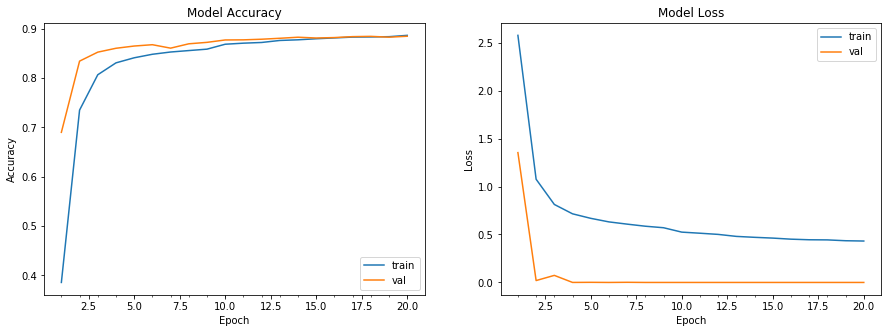

505/505 [==============================] - 26s 52ms/step
Validation Precision: 0.934892
Validation Recall: 0.858639
Validation F1 score: 0.882521


/home/miber/.local/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/miber/.local/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


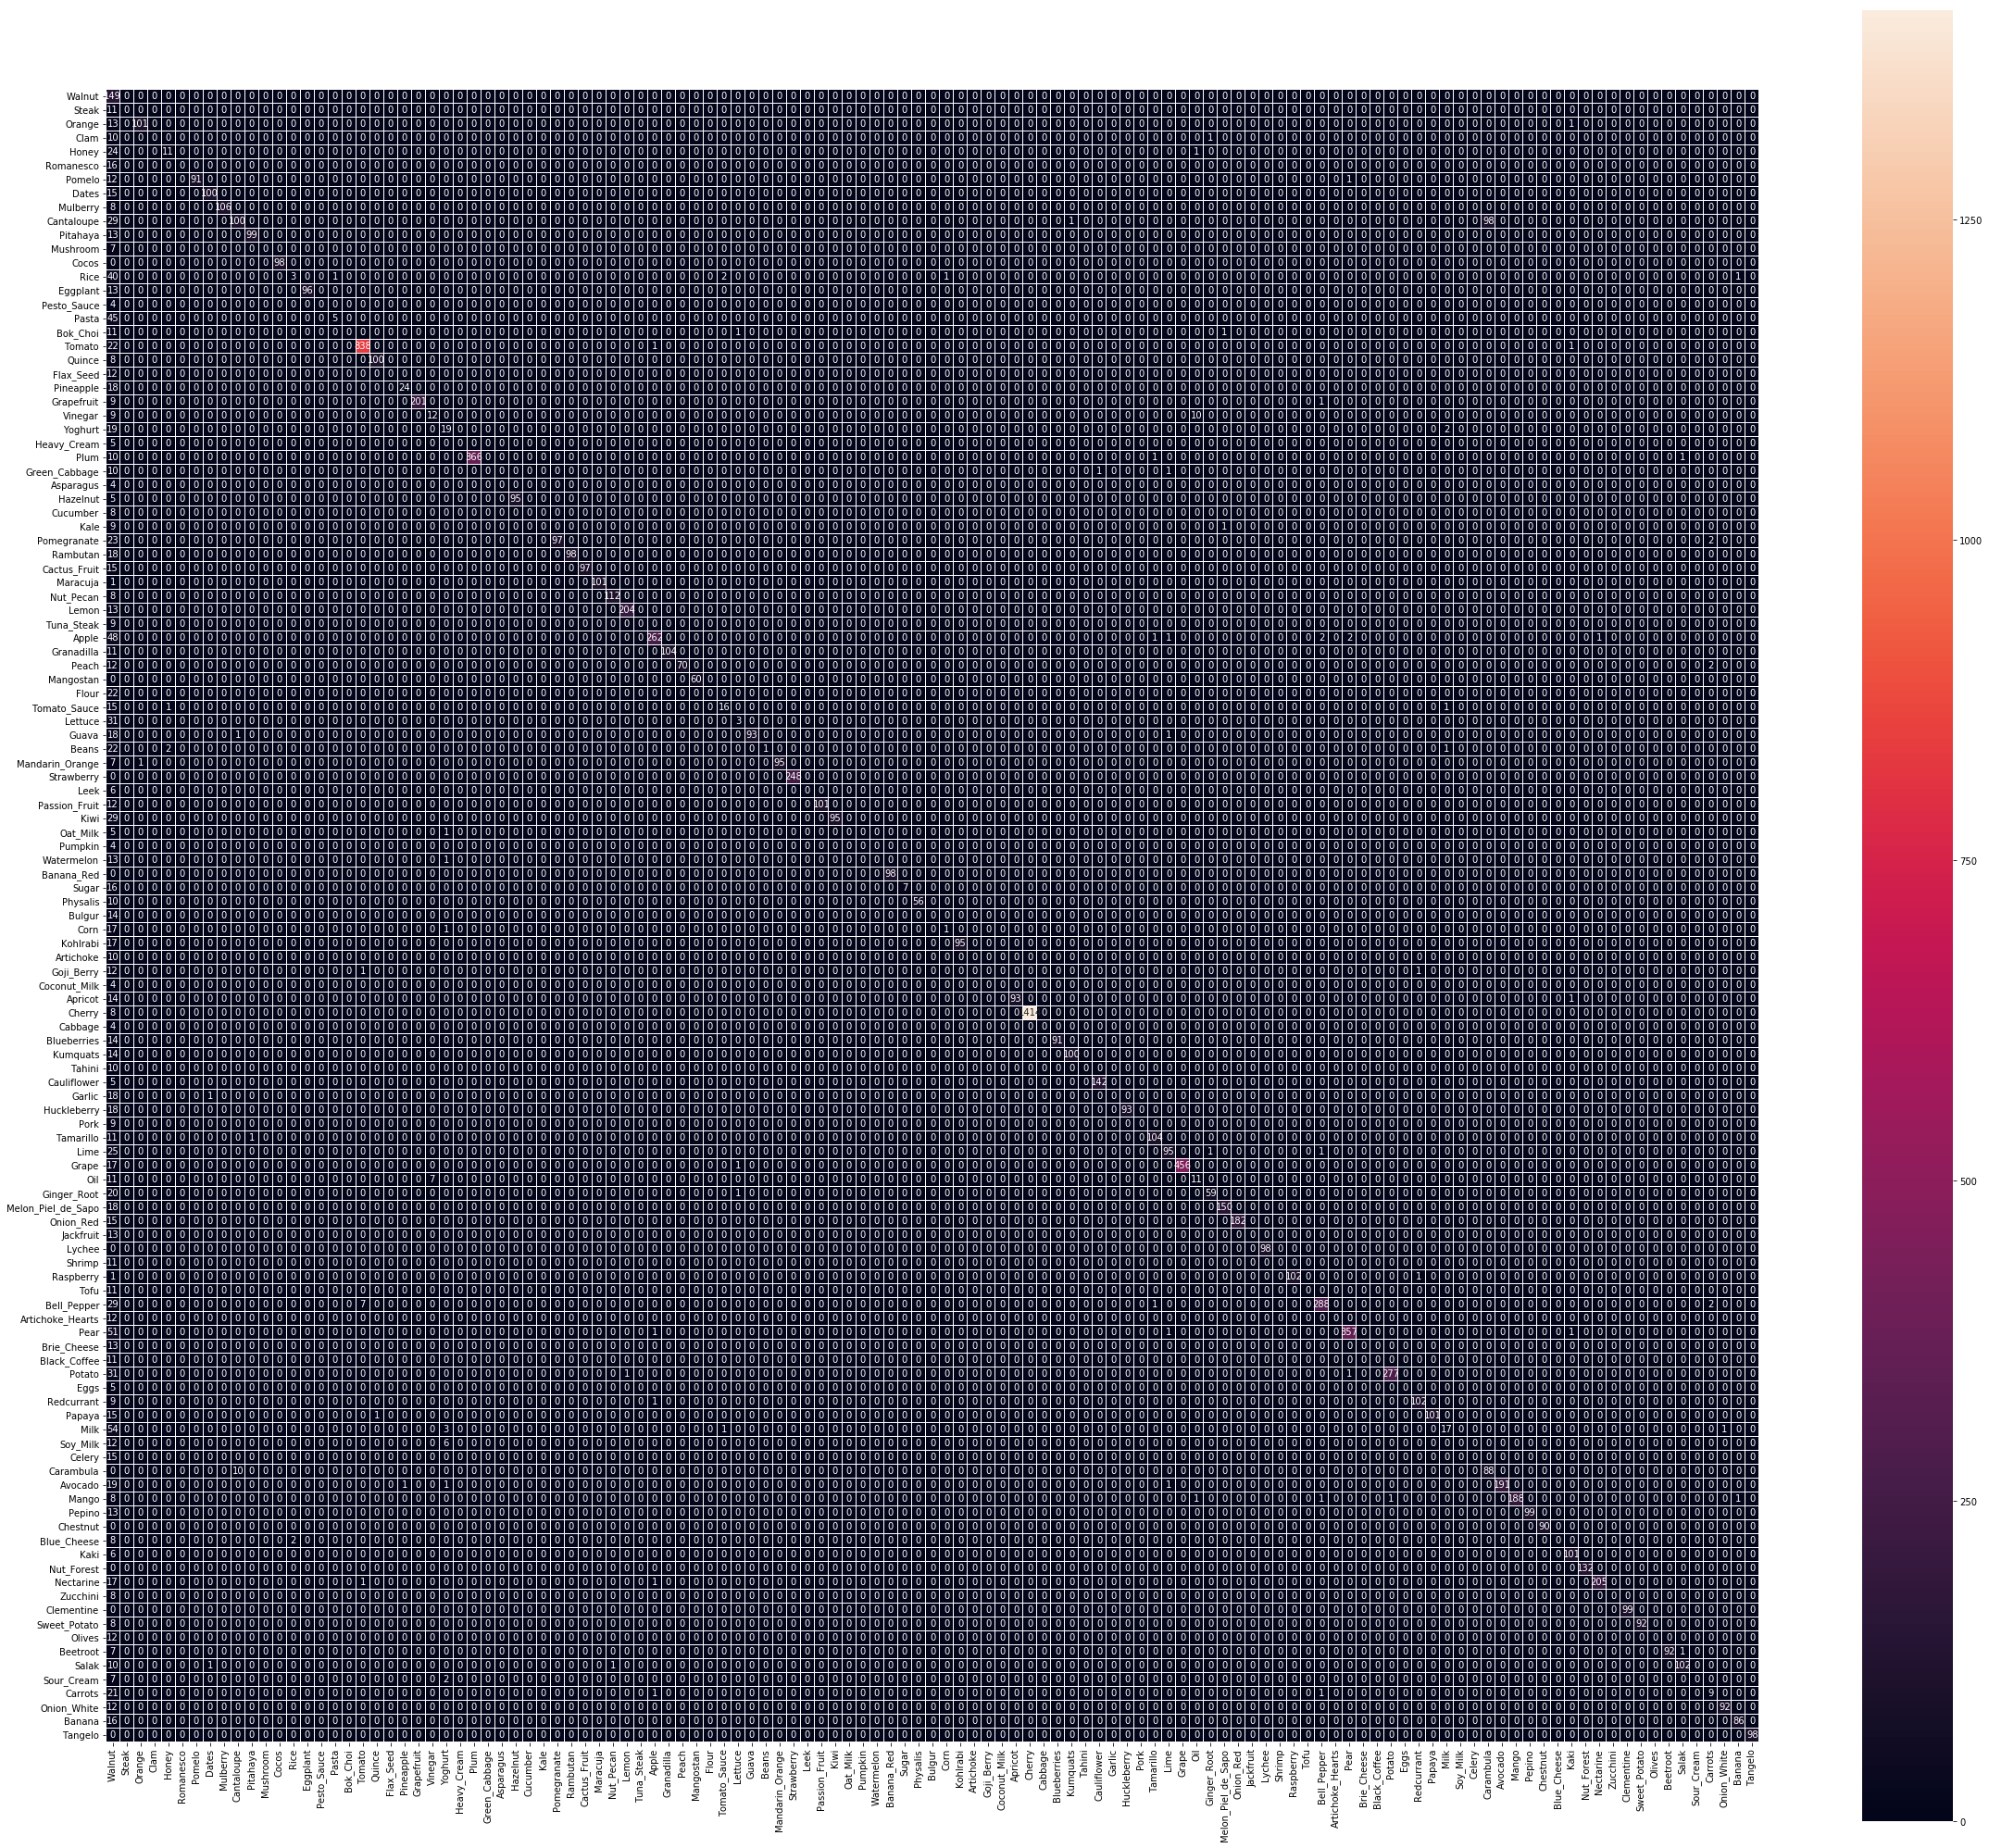

In [10]:
# Model set up and learning: Base Model (CNN + FF with Softmax Activation)
# Based on https://github.com/Horea94/Fruit-Images-Dataset

def image_process(x):
    '''
    Creates a custom layer that converts the original image from 
    RGB to HSV and grayscale and concatenates the results
    '''
    import tensorflow as tf # needs to be in here, when loading the model back in
    
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    image = tf.concat([hsv, gray], axis=-1)
    return image


def cnn_softmax_model(input_shape, num_classes):
    '''
    The Model: 
    - CNN with relu activation and max pooling, 5 CNN layers
    - 3 feed forward layers with dropout with one softmax activation afterward
    '''
    
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(image_process)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Conv2D(254, (5, 5), strides=(1, 1), padding='same', name='conv5')(x)
    x = Activation('relu', name='conv5_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool5')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(500, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    x = Dense(200, activation='relu', name='fcl3')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    model = Model(inputs=img_input, outputs=out)
    return model

# Training and evaluating the model
model = cnn_softmax_model(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="ingredients_detection_model",  loss="sparse_categorical_crossentropy")

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(119, name="svm", kernel_regularizer=<keras.reg...)`


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 100, 100, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 100, 100, 4)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1616      
_________________________________________________________________
conv1_relu (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 50, 50, 32)        12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 50, 50, 32)        0   

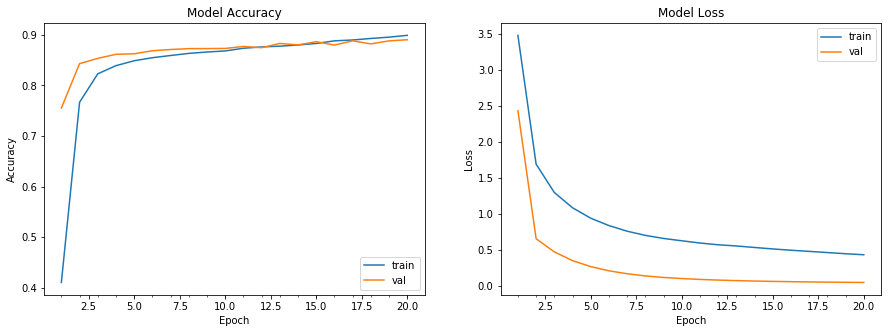

505/505 [==============================] - 21s 42ms/step
Validation Precision: 0.926441
Validation Recall: 0.874108
Validation F1 score: 0.888292


/home/miber/.local/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/miber/.local/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


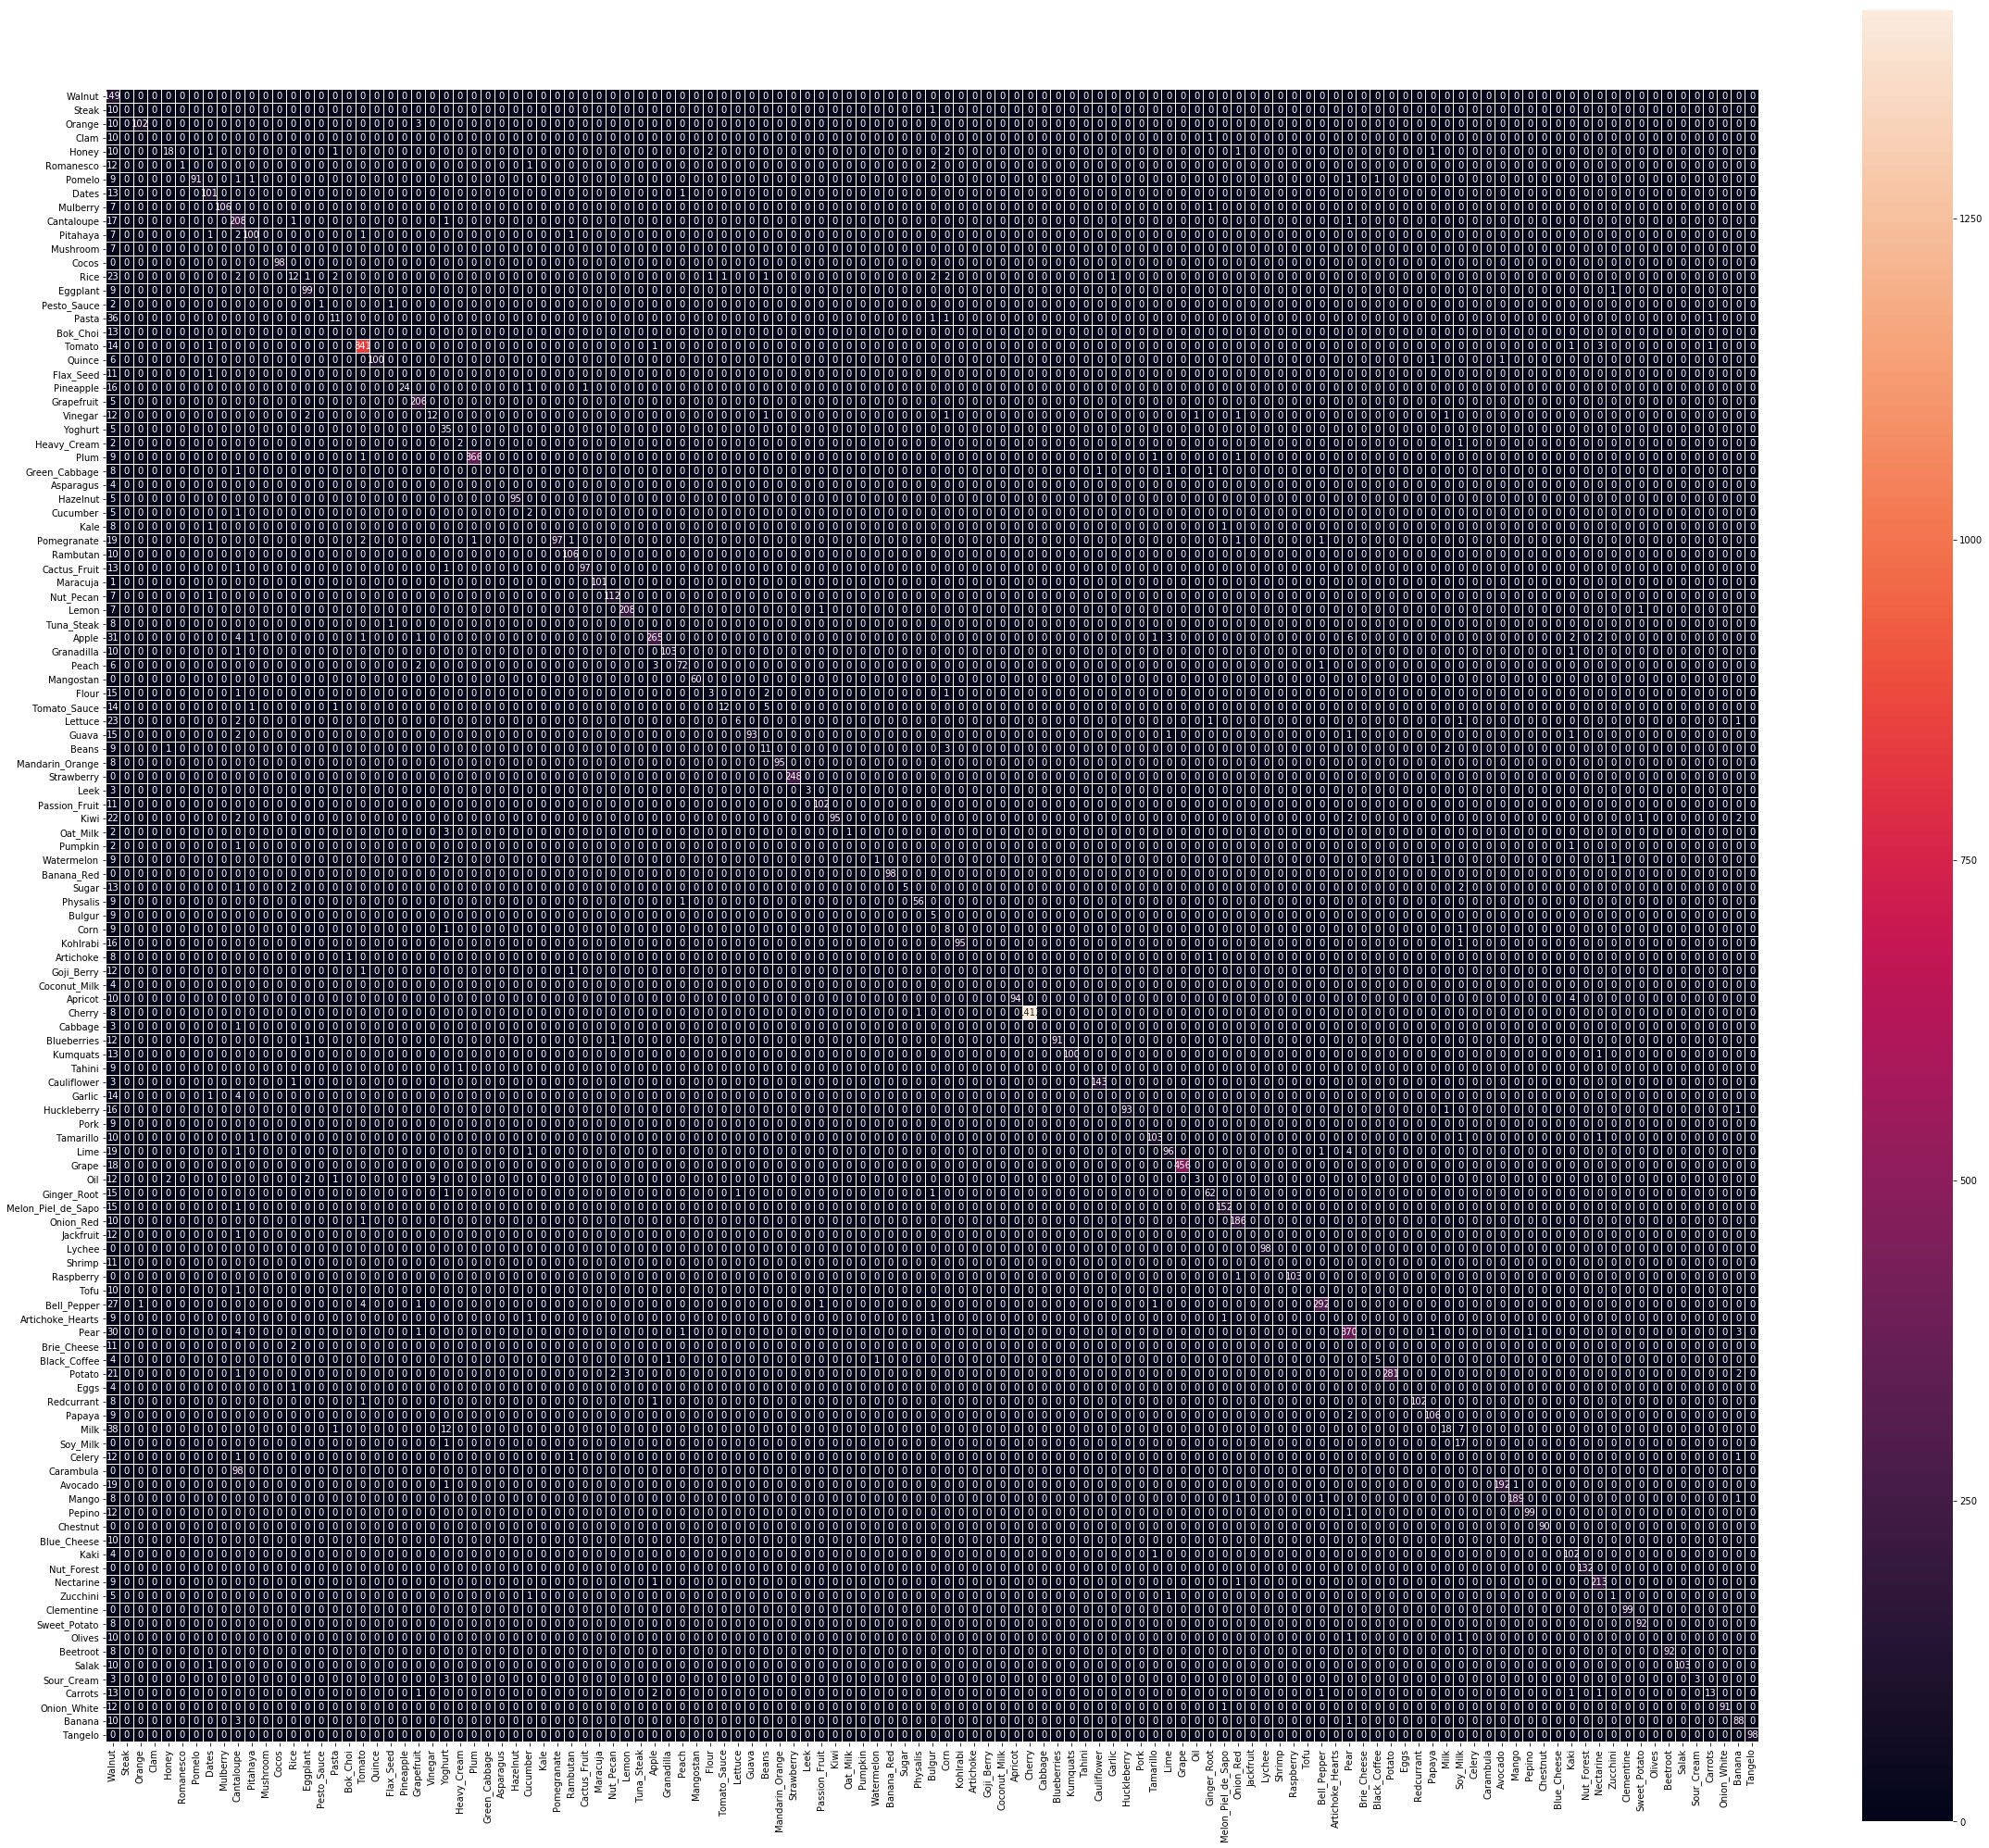

In [11]:
# Model set up and learning: With SVM
# Based on https://github.com/Horea94/Fruit-Images-Dataset
from keras.regularizers import l2

def image_process(x):
    '''
    Creates a custom layer that converts the original image from 
    RGB to HSV and grayscale and concatenates the results
    '''
    import tensorflow as tf # needs to be in here, when loading the model back in

    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    image = tf.concat([hsv, gray], axis=-1)
    return image


def cnn_svm_model(input_shape, num_classes):
    '''
    The Model: 
    - CNN with relu activation and max pooling, 6 CNN layers
    - 3 feed forward layers with dropout with one softmax activation afterward
    '''
    
    img_input = Input(shape=input_shape, name='data')
    x = Lambda(image_process)(img_input)
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Conv2D(254, (5, 5), strides=(1, 1), padding='same', name='conv5')(x)
    x = Activation('relu', name='conv5_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool5')(x)
    x = Conv2D(508, (5, 5), strides=(1, 1), padding='same', name='conv6')(x)
    x = Activation('relu', name='conv6_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool6')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(500, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    x = Dense(200, activation='relu', name='fcl3')(x)
    x = Dropout(0.2)(x)
    x = Dense(num_classes, name='svm', W_regularizer=l2(weight))(x)
    out = Dense(num_classes, activation='softmax', name='prediction')(x)
    model = Model(inputs=img_input, outputs=out)
    return model

# Training and evaluating the model
model = cnn_svm_model(input_shape=input_shape, num_classes=num_classes)
train_and_evaluate_model(model, name="ingredients_detection_model_hinge", loss='categorical_hinge')

In [12]:
# Making single image predictions
# Loading model
import sys
from keras.models import load_model
from keras.optimizers import Adadelta
import cv2
import numpy as np
import os

# load model
model = load_model('/home/miber/creative-cooking/ingredients_training_output_files/ingredients_detection_model/model.h5')

# Load and resize image
image_size = (100, 100)
input_shape = (1, 100, 100, 3) 

image = '/home/miber/data/ingredients-images/ingredients-train/Lettuce/Lettuce_134.jpg'

image = cv2.imread(image)
#image = preprocess_background(image)
image = cv2.resize(image, image_size)
image = np.reshape(image, input_shape)

# Run model
learning_rate = 0.1
optimizer = Adadelta(lr=learning_rate)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

prediction = model.predict(image)

# Format prediction
label_file = '/home/miber/creative-cooking/labels.txt'

with open(label_file, "r") as f:
    labels = [x.rstrip('\n') for x in f.readlines()]

print('Prediction Ingredient:')

for ingredient, prob in sorted(list(zip(labels, prediction[0])), key = lambda x: -x[1])[:5]:
    print('{}: {:.2f}%'.format(ingredient, round(prob, 4) * 100))

Prediction Ingredient:
Lettuce: 40.65%
Ginger_Root: 12.23%
Kiwi: 11.33%
Melon_Piel_de_Sapo: 5.31%
Bok_Choi: 5.05%


In [15]:
!python3 ./ingredients-prediction-with-preprocessing.py n /home/miber/data/ingredients-images/ingredients-train/Lettuce/Lettuce_134.jpg

Lettuce: 40.65%
Ginger Root: 12.23%
Kiwi: 11.33%
Melon Piel de Sapo: 5.31%
Bok Choi: 5.05%


In [14]:
# Making single image predictions
# Loading model
import sys
from keras.models import load_model
from keras.optimizers import Adadelta
import cv2
import numpy as np
import os

# load model

model = load_model('/home/miber/creative-cooking/ingredients_training_output_files/ingredients_detection_model_hinge/model.h5')

# Load and resize image
image_size = (100, 100)
input_shape = (1, 100, 100, 3) 

image = '/home/miber/data/ingredients-images/ingredients-train/Lettuce/Lettuce_134.jpg'

image = cv2.imread(image)
#image = preprocess_background(image)
image = cv2.resize(image, image_size)
image = np.reshape(image, input_shape)

# Run model
learning_rate = 0.1
optimizer = Adadelta(lr=learning_rate)
model.compile(optimizer=optimizer, loss="categorical_hinge", metrics=["accuracy"])

prediction = model.predict(image)

# Format prediction
label_file = '/home/miber/creative-cooking/labels.txt'

with open(label_file, "r") as f:
    labels = [x.rstrip('\n') for x in f.readlines()]

print('Prediction Ingredient:')

for ingredient, prob in sorted(list(zip(labels, prediction[0])), key = lambda x: -x[1])[:5]:
    print('{}: {:.2f}%'.format(ingredient, round(prob, 4) * 100))

Prediction Ingredient:
Ginger_Root: 34.17%
Lettuce: 17.15%
Pasta: 3.79%
Bok_Choi: 3.60%
Bulgur: 3.44%


In [22]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./model-export/icn/tflite-ingredients_detection_mobile-2020-02-09T16:42:35.238Z/model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
input_details

[{'dtype': numpy.uint8,
  'index': 0,
  'name': 'image',
  'quantization': (0.007874015718698502, 128),
  'shape': array([  1, 224, 224,   3], dtype=int32)}]

In [24]:
output_details

[{'dtype': numpy.uint8,
  'index': 172,
  'name': 'scores',
  'quantization': (0.00390625, 0),
  'shape': array([  1, 119], dtype=int32)}]

In [25]:
import cv2
image_size = (224, 224)
input_shape = (1, 224, 224, 3)
image = '/home/miber/data/ingredients-images/ingredients-train/Lettuce/Lettuce_134.jpg'
image = cv2.imread(image)
image = cv2.resize(image, image_size)
image = np.reshape(image, input_shape)


In [27]:
# Test model on random input data.
input_data = image
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[  0   0   1   0   0   0   3   0   0   0   0   0   0   4   0   1   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0   2
    0   0   1   1   0  15   0   0   0   0   0   1   1   1   0   0   0   0
    0   0   0   1   0   0   0   1   0   0   0   0   0   0 181   0   0   1
    0   1   0   0   0   0   1   0   1   0   0   2   0   0   2   1   0   0
    0   1   0   1   0   0   1   1   0   1   0   0   1   1   1   1   1   1
    0   0   1   1   1   0   0   0   0   0   0]]


In [32]:
predict_file = "./model-export/icn/tflite-ingredients_detection_mobile-2020-02-09T16:42:35.238Z/dict.txt"
with open(predict_file, "r") as f:
    labels = [x.rstrip('\n') for x in f.readlines()]

In [66]:
total = np.sum(output_data[0])
for i in sorted(np.argpartition(output_data[0], -5)[-5:], key=lambda x: -x):
    print("{:<20s} | Score: {}%".format(labels[i], str(round(output_data[0][i]/total * 100, 2))))

Lettuce              | Score: 75.42%
Kale                 | Score: 6.25%
Apricot              | Score: 1.25%
Ginger_Root          | Score: 1.67%
Beetroot             | Score: 1.25%


In [75]:
!python3 edge_model_ingredient_prediction.py /home/miber/data/ingredients-images/ingredients-train/Lettuce/Lettuce_134.jpg

Lettuce              | Score: 75.42%
Kale                 | Score: 6.25%
Apricot              | Score: 1.25%
Ginger_Root          | Score: 1.67%
Beetroot             | Score: 1.25%
